In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsbombpy import sb
from mplsoccer import VerticalPitch
from scipy.stats import  binned_statistic_2d

from sklearn.cluster import KMeans

from PIL import Image


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
# Using color that are accesible for colorblind people
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
# Using the Statsbombpy package to the get the Statsbomb 360 data and freeze frames for the 2020 UEFA Euro

df_events = sb.competition_events(
            country="Europe",
            division="UEFA Euro",
            season="2020",
)

/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/site-packages/statsbombpy/api_client.py:21: 

In [7]:
# create separate dataframes for passes and carries
df_passes = df_events[df_events['type'] == 'Pass'].copy()
df_carries = df_events[df_events['type'] == 'Carry'].copy()


In [8]:
# splitting the x and y locations into two separate columns
# It was necessary to do it after creating the separate dataframes to handle null values in the location column
df_passes['location_x'] = df_passes['location'].apply(lambda x: x[0])
df_passes['location_y'] = df_passes['location'].apply(lambda x: x[1])

df_carries['location_x'] = df_carries['location'].apply(lambda x: x[0])
df_carries['location_y'] = df_carries['location'].apply(lambda x: x[1])

# splitting the x and y end locations into two separate columns
df_passes['end_location_x'] = df_passes['pass_end_location'].apply(lambda x: x[0])
df_passes['end_location_y'] = df_passes['pass_end_location'].apply(lambda x: x[1])

df_carries['end_location_x'] = df_carries['carry_end_location'].apply(lambda x: x[0])
df_carries['end_location_y'] = df_carries['carry_end_location'].apply(lambda x: x[1])

In [9]:
# Filtering out the passes we want into a new dataframe: Successful passes starting out in the first third (0-40) and ending up beyond the first third (40-120).
df_passes_out_own_third = df_passes[
    (df_passes['position'].isin(['Right Center Back', 'Center Back', 'Left Center Back']))
    & df_passes['pass_outcome'].isna()
    & (df_passes['location_x'] <= 40)
    & (df_passes['end_location_x'] >= 40)
    ]

In [10]:
# Filtering out the carries we want into a new dataframe: Carries starting out in the first third (0-40) and ending up beyond the first third (40-120).
df_carries_out_own_third = df_carries[
    (df_carries['position'].isin(['Right Center Back', 'Center Back', 'Left Center Back']))
    & (df_carries['location_x'] <= 40)
    & (df_carries['end_location_x'] >= 40)
    ]

In [11]:
# Because there are too many passes to plot into one visualization, I use KMeans to cluster the passes into 30 clusters. 
# I use Devin Pleuler's tutorial to do the clustering: https://colab.research.google.com/github/devinpleuler/analytics-handbook/blob/master/soccer_analytics_handbook.ipynb#scrollTo=K_Means
# Clustering for passes
model1 = KMeans(n_clusters=30)
features1 = df_passes_out_own_third[['location_x', 'location_y', 'end_location_x', 'end_location_y']]
fit1 = model1.fit(features1)

# flip the clusters array for easier plotting
pass_clusters = fit1.cluster_centers_.T

# Clustering for carries
model2 = KMeans(n_clusters=30)
features2 = df_carries_out_own_third[['location_x', 'location_y', 'end_location_x', 'end_location_y']]
fit2 = model2.fit(features2)

# flip the clusters array for easier plotting
carry_clusters = fit2.cluster_centers_.T

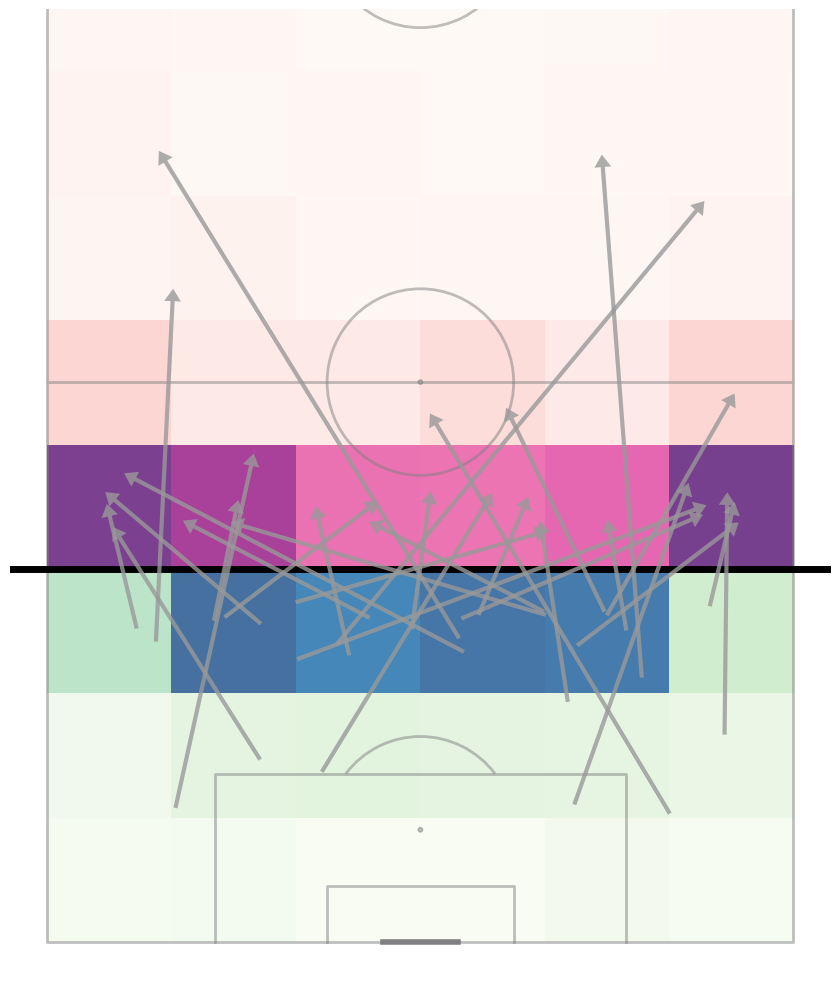

In [12]:
pitch = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-20)
fig, ax = pitch.draw(figsize=(12,10))

passes_own_third_end = binned_statistic_2d(df_passes_out_own_third['end_location_x'], df_passes_out_own_third['end_location_y'], None, statistic='count', bins=(6, 6))
passes_own_third_start = binned_statistic_2d(df_passes_out_own_third['location_x'], df_passes_out_own_third['location_y'], None, statistic='count', bins=(3, 6))
ax.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
plt.imshow(passes_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
plt.imshow(passes_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)

p1 = pitch.arrows(pass_clusters[0], pass_clusters[1], pass_clusters[2],pass_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax, zorder=20, alpha=0.8)
    

plt.show()

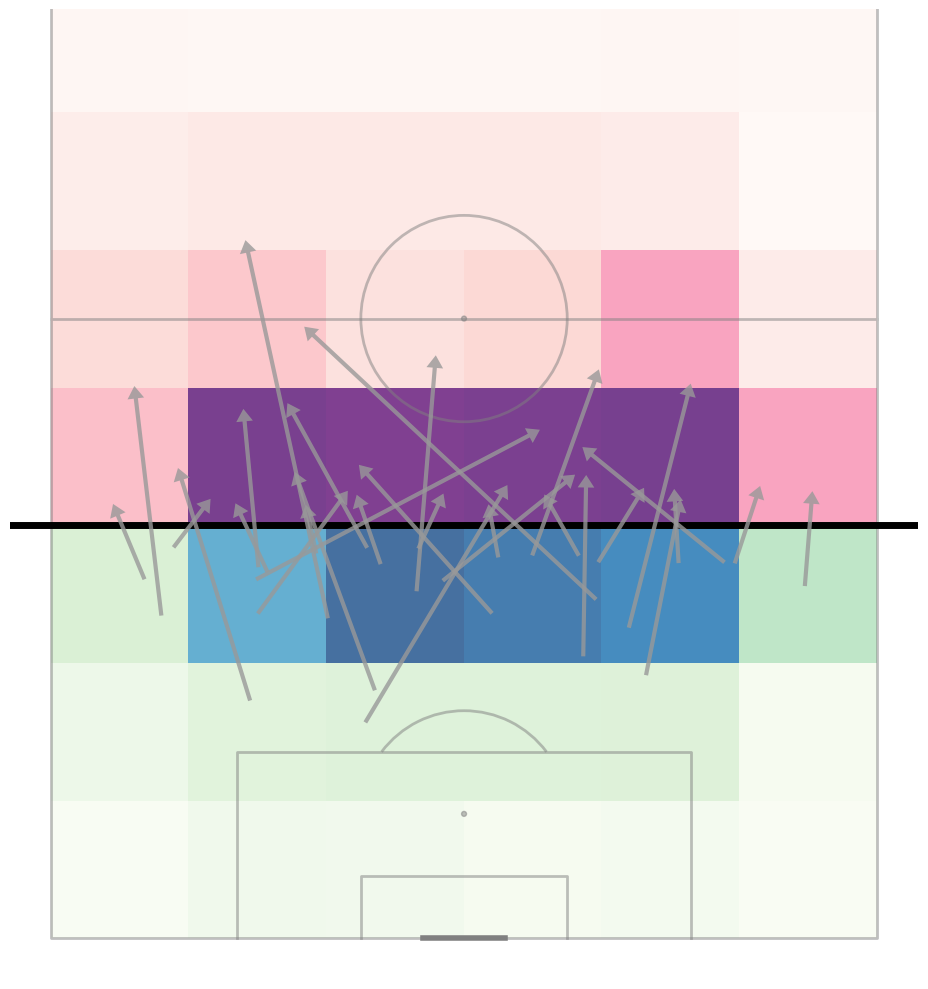

In [13]:
pitch = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-30)
fig, ax = pitch.draw(figsize=(12,10))

carries_own_third_end = binned_statistic_2d(df_carries_out_own_third['end_location_x'], df_carries_out_own_third['end_location_y'], None, statistic='count', bins=(6, 6))
carries_own_third_start = binned_statistic_2d(df_carries_out_own_third['location_x'], df_carries_out_own_third['location_y'], None, statistic='count', bins=(3, 6))
ax.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
plt.imshow(carries_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
plt.imshow(carries_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)

p1 = pitch.arrows(carry_clusters[0], carry_clusters[1], carry_clusters[2],carry_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax, zorder=20, alpha=0.8)

plt.show()

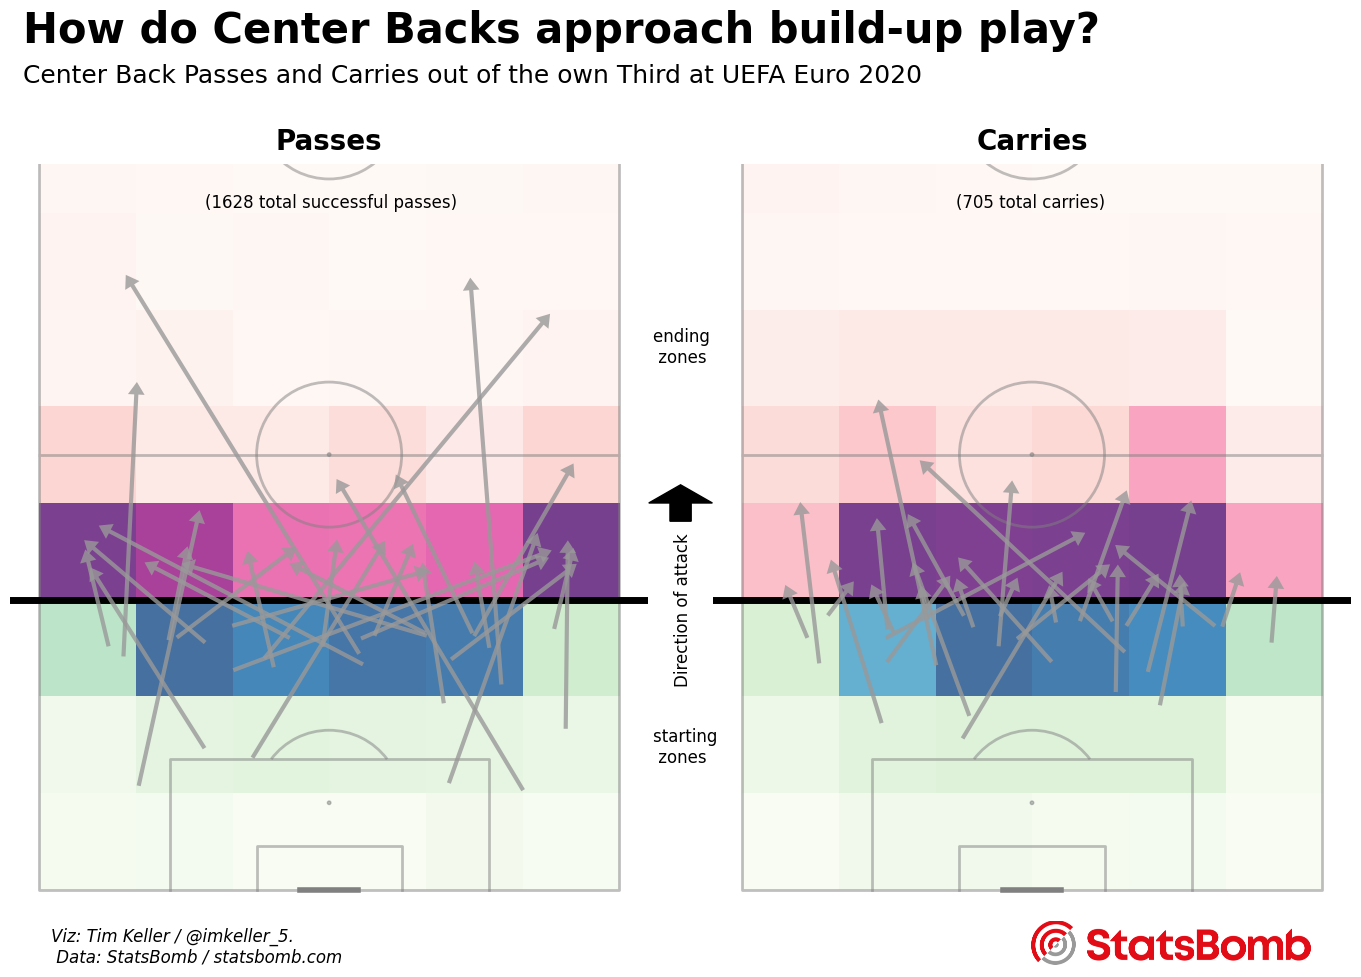

In [14]:
# Combine both graphics into one visualization
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)
# Create the first of two vertical pitches for the passes
pitch1 = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-20)
pitch1.draw(figsize=(12,10), ax=ax1)

# Add the headings to graph
fig.text(0.03,1.1,'How do Center Backs approach build-up play?', fontsize=30, fontweight='bold')
fig.text(0.03,1.05,'Center Back Passes and Carries out of the own Third at UEFA Euro 2020', fontweight='regular',fontsize=18)

ax1.annotate('Passes', xy=(0.5, 1.03), xycoords='axes fraction', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(0.25, 0.9,"({} total successful passes)".format(df_passes_out_own_third.shape[0]), fontsize=12, ha='center', va='center')

# Binning the passes according to their start and end locations
passes_own_third_end = binned_statistic_2d(df_passes_out_own_third['end_location_x'], df_passes_out_own_third['end_location_y'], None, statistic='count', bins=(6, 6))
passes_own_third_start = binned_statistic_2d(df_passes_out_own_third['location_x'], df_passes_out_own_third['location_y'], None, statistic='count', bins=(3, 6))
# horizontal line to visually separate the the first and second third of the pitch
ax1.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
# plotting the bins as heatmaps
ax1.imshow(passes_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
ax1.imshow(passes_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)
# plotting cluster centers as arrows
p1 = pitch1.arrows(pass_clusters[0], pass_clusters[1], pass_clusters[2],pass_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax1, zorder=20, alpha=0.8)
    
# Create the second vertical pitch for carries
pitch2 = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-20)
pitch2.draw(figsize=(12,10), ax=ax2)

ax2.annotate('Carries', xy=(0.5, 1.03), xycoords='axes fraction', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(0.75, 0.9,"({} total carries)".format(df_carries_out_own_third.shape[0]), fontsize=12, ha='center', va='center')

# Binning the passes according to their start and end locations
carries_own_third_end = binned_statistic_2d(df_carries_out_own_third['end_location_x'], df_carries_out_own_third['end_location_y'], None, statistic='count', bins=(6, 6))
carries_own_third_start = binned_statistic_2d(df_carries_out_own_third['location_x'], df_carries_out_own_third['location_y'], None, statistic='count', bins=(3, 6))
# horizontal line to visually separate the the first and second third of the pitch
ax2.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
# plotting the bins as heatmaps
ax2.imshow(carries_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
ax2.imshow(carries_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)

# plotting cluster centers as arrows
p2 = pitch2.arrows(carry_clusters[0], carry_clusters[1], carry_clusters[2],carry_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax2, zorder=20, alpha=0.8)

# Adding the Statsbomb logo to comply with the open data license requirements
ax3 = fig.add_axes([0.75,-0.125,0.2,0.2]) # badge
ax3.axis('off')
img = Image.open('statsbomb_logo.png')
ax3.imshow(img)

# Addiontal labelling for the graph
fig.text(0.05, -0.05, "Viz: Tim Keller / @imkeller_5.  \n Data: StatsBomb / statsbomb.com",
        fontstyle="italic",fontsize=12)
ax5 = fig.add_axes([0.475,0.5,0.05,0.05]) # badge
ax5.axis('off')
ax5.arrow(0, 0, 0, 20, head_length=20, head_width=1.5, width=0.5,fc='k', ec='k')
fig.text(0.495, 0.3, "Direction of attack",fontsize=12, rotation=90 )
fig.text(0.48, 0.2, "starting \n zones",fontsize=12)
fig.text(0.48, 0.7, "ending \n zones",fontsize=12)

plt.show()

fig.savefig('figs/src-ftbl-project-center-back-build-up.png',bbox_inches='tight')

In [15]:
# Filtering for a team to be able to create team specific graphics.
team = "Spain"
df_carries_team = df_carries_out_own_third[df_carries_out_own_third['team'] == team]
df_passes_team = df_passes_out_own_third[df_passes_out_own_third['team'] == team]

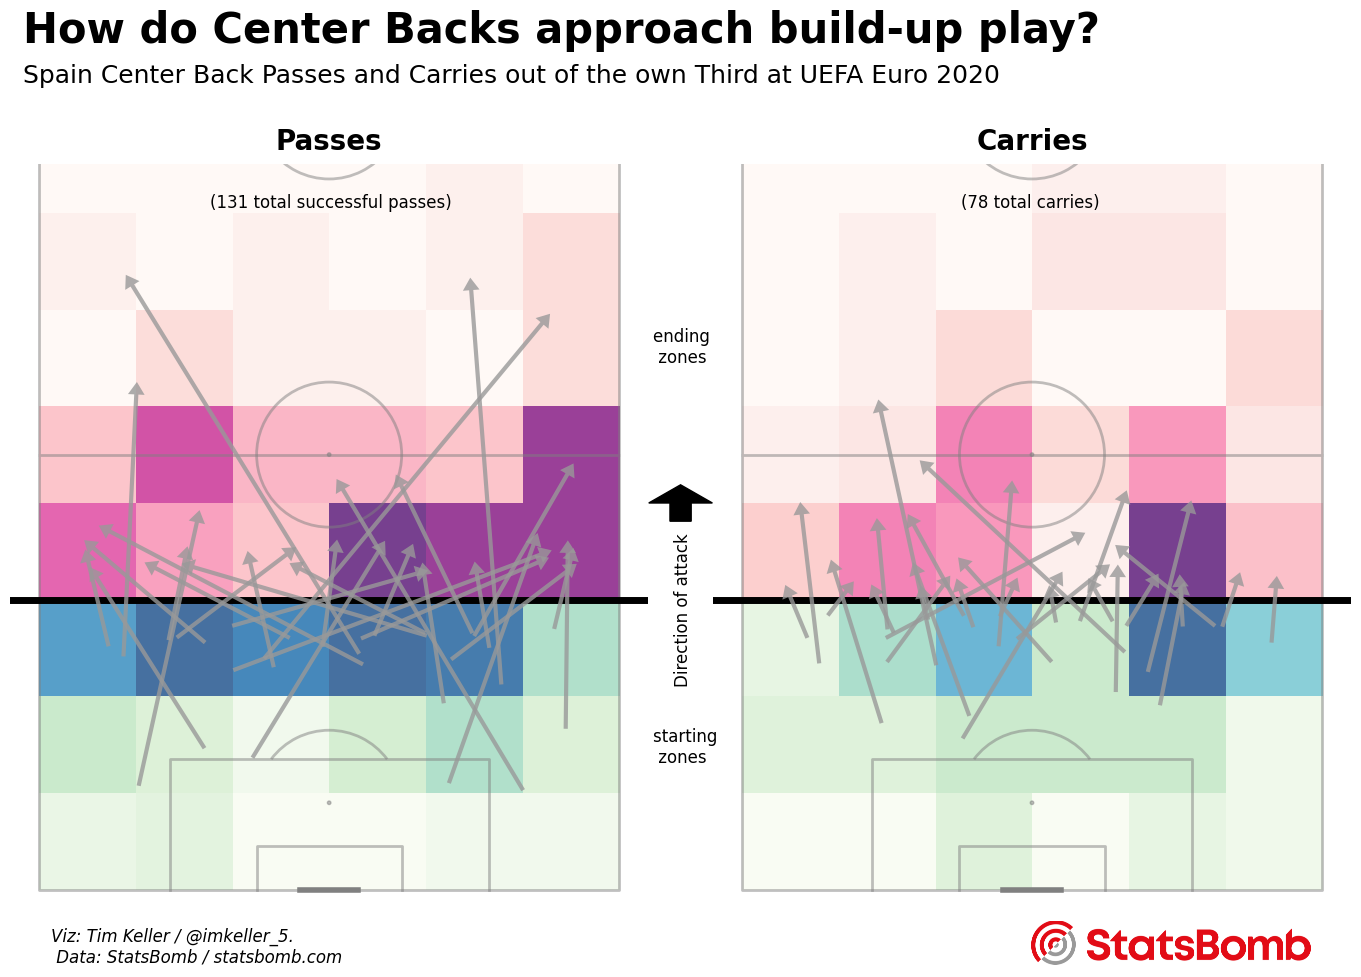

In [16]:
# Same visualization but team specific
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)

# Create the first of two vertical pitches for the passes
pitch1 = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-20)
pitch1.draw(figsize=(12,10), ax=ax1)

# Add the headings to graph
fig.text(0.03,1.1,'How do Center Backs approach build-up play?', fontsize=30, fontweight='bold')
fig.text(0.03,1.05,'{} Center Back Passes and Carries out of the own Third at UEFA Euro 2020'.format(team), fontweight='regular',fontsize=18)

ax1.annotate('Passes', xy=(0.5, 1.03), xycoords='axes fraction', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(0.25, 0.9,"({} total successful passes)".format(df_passes_team.shape[0]), fontsize=12, ha='center', va='center')

# Binning the passes according to their start and end locations
passes_own_third_end = binned_statistic_2d(df_passes_team['end_location_x'], df_passes_team['end_location_y'], None, statistic='count', bins=(6, 6))
passes_own_third_start = binned_statistic_2d(df_passes_team['location_x'], df_passes_team['location_y'], None, statistic='count', bins=(3, 6))
# horizontal line to visually separate the the first and second third of the pitch
ax1.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
# plotting the bins as heatmaps
ax1.imshow(passes_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
ax1.imshow(passes_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)

# plotting cluster centers as arrows
p1 = pitch1.arrows(pass_clusters[0], pass_clusters[1], pass_clusters[2],pass_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax1, zorder=20, alpha=0.8)
    
# Create the second vertical pitch for carries
pitch2 = VerticalPitch(half=False, pitch_type='statsbomb', line_zorder=4, line_color='grey', line_alpha=0.5, pad_top=-20)
pitch2.draw(figsize=(12,10), ax=ax2)

ax2.annotate('Carries', xy=(0.5, 1.03), xycoords='axes fraction', fontsize=20, ha='center', va='center', fontweight='bold')
fig.text(0.75, 0.9,"({} total carries)".format(df_carries_team.shape[0]), fontsize=12, ha='center', va='center')

# Binning the passes according to their start and end locations
carries_own_third_end = binned_statistic_2d(df_carries_team['end_location_x'], df_carries_team['end_location_y'], None, statistic='count', bins=(6, 6))
carries_own_third_start = binned_statistic_2d(df_carries_team['location_x'], df_carries_team['location_y'], None, statistic='count', bins=(3, 6))
# horizontal line to visually separate the the first and second third of the pitch
ax2.axhline(y=40, xmin=0, xmax=80, color='black', alpha=1, zorder=10, linewidth=5)
# plotting the bins as heatmaps
ax2.imshow(carries_own_third_end.statistic, cmap='RdPu', origin='lower', extent=[0, 80, 40, 120], alpha=0.75, zorder=3)
ax2.imshow(carries_own_third_start.statistic, cmap='GnBu', origin='lower', extent=[0, 80, 0, 40], alpha=0.75, zorder=3)

# plotting cluster centers as arrows
p2 = pitch2.arrows(carry_clusters[0], carry_clusters[1], carry_clusters[2],carry_clusters[3], color=CB_color_cycle[6],
                headaxislength=3, headlength=3, headwidth=4, width=3, ax=ax2, zorder=20, alpha=0.8)

# Adding the Statsbomb logo to comply with the open data license requirements
ax3 = fig.add_axes([0.75,-0.125,0.2,0.2]) # badge
ax3.axis('off')
img = Image.open('statsbomb_logo.png')
ax3.imshow(img)

# Addiontal labelling for the graph
fig.text(0.05, -0.05, "Viz: Tim Keller / @imkeller_5.  \n Data: StatsBomb / statsbomb.com",
        fontstyle="italic",fontsize=12)
ax5 = fig.add_axes([0.475,0.5,0.05,0.05]) # badge
ax5.axis('off')
ax5.arrow(0, 0, 0, 20, head_length=20, head_width=1.5, width=0.5,fc='k', ec='k')
fig.text(0.495, 0.3, "Direction of attack",fontsize=12, rotation=90 )
fig.text(0.48, 0.2, "starting \n zones",fontsize=12)
fig.text(0.48, 0.7, "ending \n zones",fontsize=12)

plt.show()

fig.savefig('figs/src-ftbl-project-center-back-build-up-{}.png'.format(team),bbox_inches='tight')
